# ATMS 523 - Module 2
## `dask` workflows with `xarray`

In this notebook, we will examine a couple of workflows for using `dask` with `xarray`, which is a common flow for working with weather and climate data.

Let's fire up a `dask` client on our local machine.

In [1]:
from dask.distributed import Client, progress
dask.config.set(temporary_directory='/tmp/snesbitt/dask-worker/')

In [2]:
client = Client()  # set up local cluster on your laptop
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:63167,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:63207,Total threads: 2
Dashboard: http://127.0.0.1:63208/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:63173,


`xarray` is the most common way netCDF files are used to store and access weather and climate data, and it is a self describing format.  Other popular binary data formats are HDF and GRIB, but no worries, `xarray` can access those too (with some backend software that you can install).  

Earlier this module, you reviewed `xarray` usage - now let's extend this to some more advanced usage for processing large datasets!

---

There are several way to work with `dask` to process large datasets.  You can do an *en masse* processing, or you can do sequential processing where you feed a function to dask and it processes a task (think: more of like a for loop in python.  The former is best for a relatively small number of files (<1000), while the latter can be better for large numbers of files, due to limitations in how having many files open at once can impact performance on computers.  One thing to note that performance tuning in dask go hand in hand, especially if you need to tune the performance of a workflow for an operational setting where time is of the essence.

Let's try the *en masse* processing of some reanalysis data!

Here, we will do some processing of the European Center for Medium-range Weather Forecasts (ECMWF) ERA-5 project data.  We will grab the monthly mean data from the cloud using a technology called THREDDS/OPENDAP, which is a cloud-based file distribution system.  This allows you to access data in the cloud from a provider without downloading it to your local machine.  

Our provider will be the National Center for Atmospheric Research (NCAR) Research Data Archive (RDA), which provides a huge amount of data for analysis in a huge THREDDS "data lake"! Their website for data discovery is: [https://rda.ucar.edu]

I'll do a short demo for data discovery at NCAR RDA...on the video.
---
Let's do some imports.

In [2]:
import xarray as xr
import pandas as pd
import numpy as np

Let's programmatically construct a URL for the files on the THREDDS/OPENDAP server.  We need to match this pattern, and let python construct the URL based on that pattern.
```
https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_grb/e5.moda.an.sfc/1987/e5.moda.an.sfc.128_034_sstk.ll025sc.1987010100_1987120100.grb
```
So, we need to dynamically generate the year and the timestamp.  We can use `pandas` to generate a `date_range`, and then create strings that match the pattern of the file.  We'll loop over each file and create that string for each file, appending each entry to a list.

In [1]:

base_url = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/'
base_url2 = '/e5.moda.an.sfc.128_034_sstk.ll025sc.'
base_url3 = '.nc'

# period of interest
pr = pd.date_range(start='1979-01',end='2021-12', freq='AS')

file_list=[]
for dt in pr:
    # get recent year and month
    year = dt.strftime('%Y')
    month = dt.strftime('%Y%m%d%H')
    month2 = (dt + pd.DateOffset(months=11)).strftime('%Y%m%d%H')

    # build complete file name
    single_file=(base_url+year+base_url2+month+'_'+month2+base_url3)
    file_list.append(single_file)



NameError: name 'pd' is not defined

In [ ]:
file_list

['https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1979/e5.moda.an.sfc.128_034_sstk.ll025sc.1979010100_1979120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1980/e5.moda.an.sfc.128_034_sstk.ll025sc.1980010100_1980120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1981/e5.moda.an.sfc.128_034_sstk.ll025sc.1981010100_1981120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1982/e5.moda.an.sfc.128_034_sstk.ll025sc.1982010100_1982120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1983/e5.moda.an.sfc.128_034_sstk.ll025sc.1983010100_1983120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1984/e5.moda.an.sfc.128_034_sstk.ll025sc.1984010100_1984120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1985/e5.moda.an.sfc.128_034_sstk.ll025sc.1985010100_1985120100.nc',
 'https://rda.ucar.edu/thre

Now we will just pass this list to `xarray` and it will retrieve the file metadata - building an `xarray` DataSet in the process.

In [6]:
ds = xr.open_mfdataset(file_list, parallel=True,chunks={'time': '50MB'})

Let's take a look at our object.

In [7]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 516)
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
Data variables:
    utc_date   (time) int32 dask.array<chunksize=(12,), meta=np.ndarray>
    SSTK       (time, latitude, longitude) float32 dask.array<chunksize=(12, 721, 1440), meta=np.ndarray>
Attributes:
    DATA_SOURCE:                     ECMWF: https://cds.climate.copernicus.eu...
    NETCDF_CONVERSION:               CISL RDA: Conversion from ECMWF GRIB 1 d...
    NETCDF_VERSION:                  4.6.1
    CONVERSION_PLATFORM:             Linux casper02 3.10.0-693.21.1.el7.x86_6...
    CONVERSION_DATE:                 Mon Nov 11 07:46:57 MST 2019
    Conventions:                     CF-1.6
    NETCDF_COMPRESSION:              NCO: Precision-preserving compression to...
    history:                         Mon Nov 11 07:46:58 2019: ncks -4 --ppc ...
    NCO:                             netCDF Operators version 4.7.9 (Homepage...
    DODS_EXTRA.Unlimited_Dimension:  time

OK, let's calculate an El Niño-Southern Oscillation index from the ERA-5 sea surface temperature field (`SSTK` variable).  Specifically, we'll calculate the Niño 3.4 index, which is a 5-month running mean of the SST anomalies (here from the 1981-2010 mean) within the box from 5°N to 5°S latitude and 170°W to 120°W longitude (we do this via slicing; note the order we provide as the order has to follow the order of the dataset for the slicing).  We will use `xarray` to calculate the smoothed time series as well as the long term mean. 

In [8]:
# Do the slicing and take the mean over the region (latitude + longitude).  This data covers the whole period of record.

ds_sub = ds['SSTK'].sel(latitude=slice(5,-5),longitude=slice(360-170,360-120)).mean(dim=['latitude','longitude'])

# Extract the long term mean over the 1981-2010 period.

mean_1981_2010 = ds_sub.sel(time=slice('1981-1-1','2010-12-31')).mean()


Now, lets calculate the 5-month running mean, subtract the long term mean, run the computation, and plot it!

Go check out your dashboard at the link above while this is running!

This took 5 seconds on an ethernet connection at my office, but could take longer if you are on wifi or off campus.

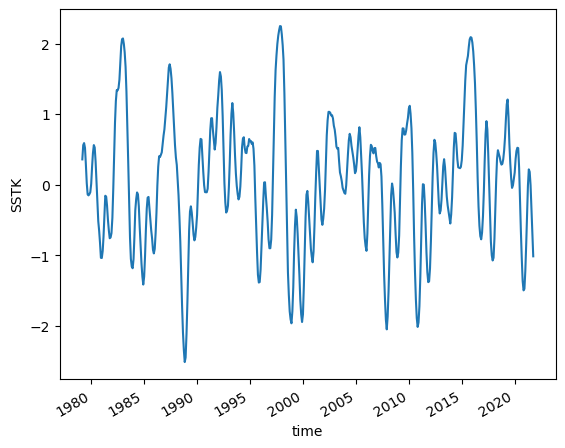

In [9]:
(ds_sub.rolling(time=5, center=True).mean() - mean_1981_2010).compute().plot()

There's an alternative way to use dask to perform computation which is a bit more flexible, and that is called a "map-reduce" workflow.  Here, you define a function, and optionally get the returns from that function, processing the dataset incrementally.  This is more like a "for loop" mentality, but you let dask handle the parallelism for you.  Here's an example.

In [11]:
def calc_mon_nino34(file):
    #note we are not using mf_dataset, because we are opening only one at a time
    ds = xr.open_dataset(file, engine='netcdf4')
    ds_sub = ds['SSTK'].sel(latitude=slice(5,-5),longitude=slice(360-170,360-120)).mean(dim=['latitude','longitude'])
    return ds_sub

#let's map the list of files to our function
raw_tser = client.map(calc_mon_nino34, file_list)

#each subset will return an xarray dataset, so we can combine using `xarray`'s `combine_by_coords`
ds_sub = xr.combine_by_coords(client.gather(raw_tser))['SSTK']
    

In [23]:
champaign_extremes = xr.load_dataset('champaign_extremes.nc')
champaign_extremes.valid_time_end_utc

ds['SSTK'].sel(time=champaign_extremes.valid_time_end_utc)

KeyError: "not all values found in index 'time'"

Now, let's calculate the running mean, climatology, and plot.  Note that I got rid of the compute call because the values were computed when we gathered the computation above.

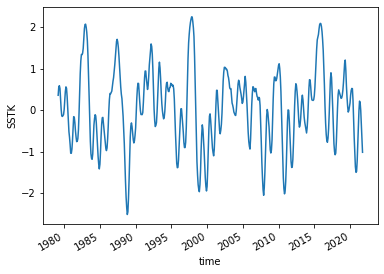

In [14]:
mean_1981_2010 = ds_sub.sel(time=slice('1981-1-1','2010-12-31')).mean()
(ds_sub.rolling(time=5, center=True).mean() - mean_1981_2010).plot()

Now you know two ways to use dask for computation.  Each can have their plusses and minuses depending on your workflow, but in both examples you are harnessing the full power of your machine, and the code is scalable up to supercomputers!

In [1]:
# Don't forget to tidy up :)

client.close()

NameError: name 'client' is not defined